In [3]:
# ==============================================================================
# LIBRARIES
# ==============================================================================
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
from tqdm import tqdm
import warnings
import requests
import time

# BioPython imports
from Bio.PDB import MMCIFParser
from Bio.PDB.Polypeptide import three_to_one
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# --- File Paths ---
MSA_FILE = '../Output/Dynamics/MSA_DF.csv'
CIF_DIR = "../Data/CIF_Files/"
REP_CHAIN_FILE = "../Output/Binding_Residue/Rep_GPCR_chain.csv"
SEQUENCE_INFO_FILE = '../Input/Human_GPCR_PDB_Info.csv'
REP_APO_FILE = "../Output/Final/Representative_Apo_Structures.csv"
OUTPUT_DIR = "../Output/Dynamics/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- NEW: Output file for TM-Only analysis ---
TM_CORRELATION_RESULTS_FILE = os.path.join(OUTPUT_DIR, "MSA_vs_3D_Correlation_TM_Only.csv")
TM_CORRELATION_FIGURE_FILE = os.path.join(OUTPUT_DIR, "Figure2c_MSA_vs_3D_Correlation_Raincloud.png")


/home/hyojin0912/anaconda3/envs/DeepREAL/lib/python3.6/site-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


In [4]:
    # 1. Load data
    df_msa = pd.read_csv(MSA_FILE)
    df_rep_chain = pd.read_csv(REP_CHAIN_FILE)
    df_seq_info = pd.read_csv(SEQUENCE_INFO_FILE)
    df_rep_apo = pd.read_csv(REP_APO_FILE)
    
    sequence_cache = df_seq_info.set_index('Entry')['Sequence'].to_dict()
    entry_name_cache = df_seq_info.set_index('Entry')['Entry Name'].to_dict()
    msa_cache = df_msa.set_index('uniprot_id')['protein_seq'].to_dict()

    # 2. Determine representative Apo PDB for each GPCR
    df_rep_apo_filtered = df_rep_apo[df_rep_apo['Binding_Coverage'] == 100.0].copy()
    df_rep_apo_filtered.sort_values(by=['UniProt_ID', 'Resolution'], ascending=[True, True], inplace=True)

In [12]:
# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================
# Function to get TM boundaries from GPCRdb API
def get_tm_boundaries(entry_name):
    """
    Fetches TM1-TM7 residue boundaries for a given GPCR entry name from GPCRdb
    using the more stable /residues/ endpoint.
    """
    # Use the lighter and more reliable /residues/ endpoint
    api_url = f"https://gpcrdb.org/services/residues/{entry_name.lower()}/"
    try:
        response = requests.get(api_url, timeout=20)
        response.raise_for_status()
        residues_data = response.json()
        
        if not residues_data:
            return None

        tm_residues = set()
        # We only want residues that are part of the 7 TM helices
        for res in residues_data:
            # The key 'protein_segment' contains the domain info (e.g., 'TM1', 'ICL1')
            if res.get('protein_segment', '').startswith('TM'):
                tm_residues.add(res['sequence_number'])
        
        return tm_residues if tm_residues else None
        
    except requests.exceptions.RequestException as e:
        print(f"Warning: API call failed for {entry_name}: {e}")
        return None

def create_msa_map(uniprot_seq, msa_seq):
    msa_map = {}
    uniprot_seq_no_gaps = uniprot_seq.replace('-', '')
    uniprot_cursor = 0
    msa_cursor = 0
    while uniprot_cursor < len(uniprot_seq_no_gaps) and msa_cursor < len(msa_seq):
        if msa_seq[msa_cursor] == '-':
            msa_cursor += 1
        else:
            msa_map[uniprot_cursor + 1] = msa_cursor
            uniprot_cursor += 1
            msa_cursor += 1
    return msa_map

def get_rep_chain_id(uniprot_id, pdb_id, df_rep_chain):
    subset = df_rep_chain[(df_rep_chain['UniProt_ID'] == uniprot_id) & (df_rep_chain['PDB_ID'] == pdb_id)]
    if subset.empty: return None
    return subset.sort_values(by='score', ascending=False).iloc[0]['chain_id']

def load_and_align_structure(pdb_id, chain_id, uniprot_seq):
    cif_path = os.path.join(CIF_DIR, f"{pdb_id.lower()}.cif")
    if not (os.path.exists(cif_path) and chain_id): return None
    try:
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure(pdb_id, cif_path)
        chain_obj = structure[0][chain_id]
        pdb_residues = [res for res in chain_obj.get_residues() if res.id[0] == ' ' and 'CA' in res]
        pdb_seq = "".join([three_to_one(res.get_resname()) for res in pdb_residues])
        if not pdb_seq: return None
        alignments = pairwise2.align.localds(uniprot_seq.replace('-', ''), pdb_seq, matlist.blosum62, -10, -0.5)
        if not alignments: return None
        aligned_uni_seq, aligned_pdb_seq, _, _, _ = alignments[0]
        final_map = {}
        pdb_res_idx = 0
        uni_pos_idx = 0
        for uni_char, pdb_char in zip(aligned_uni_seq, aligned_pdb_seq):
            if uni_char != '-':
                uni_pos_idx += 1
            if pdb_char != '-':
                if uni_char != '-':
                    final_map[uni_pos_idx] = pdb_residues[pdb_res_idx]
                pdb_res_idx += 1
        return final_map
    except Exception:
        return None

In [13]:
# ==============================================================================
# PART 1: MAIN ANALYSIS (TM-ONLY)
# ==============================================================================
def analyze_correlation_tm_only():
    """Performs MSA vs. 3D correlation analysis, restricted to the 7-TM domain."""
    print("--- Starting Analysis: MSA vs. 3D Correlation (7-TM Domain Only) ---")
    
    # 1. Load data
    df_msa = pd.read_csv(MSA_FILE)
    df_rep_chain = pd.read_csv(REP_CHAIN_FILE)
    df_seq_info = pd.read_csv(SEQUENCE_INFO_FILE)
    df_rep_apo = pd.read_csv(REP_APO_FILE)
    
    sequence_cache = df_seq_info.set_index('Entry')['Sequence'].to_dict()
    entry_name_cache = df_seq_info.set_index('Entry')['Entry Name'].to_dict()
    msa_cache = df_msa.set_index('uniprot_id')['protein_seq'].to_dict()

    # 2. Determine representative Apo PDB for each GPCR
    df_rep_apo_filtered = df_rep_apo[df_rep_apo['Binding_Coverage'] == 100.0].copy()
    df_rep_apo_filtered.sort_values(by=['UniProt_ID', 'Resolution'], ascending=[True, True], inplace=True)
    rep_apo_map = df_rep_apo_filtered.drop_duplicates(subset=['UniProt_ID'], keep='first').set_index('UniProt_ID')['PDB_ID'].to_dict()
    
    # 3. Pre-compute maps
    msa_map_cache = {uid: create_msa_map(seq, msa_cache[uid]) for uid, seq in sequence_cache.items() if uid in msa_cache}
    
    # Cache for TM boundaries to avoid repeated API calls
    tm_boundary_cache = {}
    
    correlation_results = []
    
    # 4. Loop through each GPCR
    print("Calculating correlations for each GPCR (TM-domain only)...")
    for uniprot_id, pdb_id in tqdm(rep_apo_map.items(), desc="Processing GPCRs"):
        
        # --- Get all necessary data for this GPCR ---
        uniprot_seq = sequence_cache.get(uniprot_id)
        msa_map = msa_map_cache.get(uniprot_id)
        chain_id = get_rep_chain_id(uniprot_id, pdb_id, df_rep_chain)
        entry_name = entry_name_cache.get(uniprot_id)
        
        if not all([uniprot_seq, msa_map, chain_id, entry_name]):
            continue
            
        uniprot_to_pdb_map = load_and_align_structure(pdb_id, chain_id, uniprot_seq)
        if not uniprot_to_pdb_map:
            continue
            
        # Fetch and cache TM boundaries
        if uniprot_id not in tm_boundary_cache:
            tm_boundary_cache[uniprot_id] = get_tm_boundaries(entry_name)
            time.sleep(0.1) # Be respectful to the API
        tm_residues = tm_boundary_cache[uniprot_id]
        if not tm_residues:
            print(f"Warning: Could not get TM boundaries for {uniprot_id}, skipping.")
            continue

        # --- Filter for common residues within the TM domain ---
        common_indices = sorted(list(uniprot_to_pdb_map.keys() & msa_map.keys()))
        tm_common_indices = [idx for idx in common_indices if idx in tm_residues]
        
        if len(tm_common_indices) < 30:
            continue
            
        # --- Calculate correlation ---
        coords = np.array([uniprot_to_pdb_map[i]['CA'].get_coord() for i in tm_common_indices])
        dist_3d_vector = pdist(coords, 'euclidean')
        
        msa_cols = np.array([msa_map[i] for i in tm_common_indices]).reshape(-1, 1)
        dist_msa_vector = pdist(msa_cols, 'cityblock')
        
        if np.std(dist_3d_vector) > 0 and np.std(dist_msa_vector) > 0:
            corr, _ = pearsonr(dist_3d_vector, dist_msa_vector)
            correlation_results.append({
                'UniProt_ID': uniprot_id,
                'correlation_tm_only': corr
            })

    # 5. Save results
    df_corr = pd.DataFrame(correlation_results)
    df_corr.to_csv(TM_CORRELATION_RESULTS_FILE, index=False)
    print(f"\n✅ TM-Only correlation analysis complete. Results saved to: {TM_CORRELATION_RESULTS_FILE}")
    return df_corr

In [15]:
# Part 1: Run the new TM-Only analysis
df_tm_corr = analyze_correlation_tm_only()

--- Starting Analysis: MSA vs. 3D Correlation (7-TM Domain Only) ---
Calculating correlations for each GPCR (TM-domain only)...


Processing GPCRs: 100%|██████████| 63/63 [01:57<00:00,  1.87s/it]


✅ TM-Only correlation analysis complete. Results saved to: ../Output/Dynamics/MSA_vs_3D_Correlation_TM_Only.csv


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

def plot_2c_raincloud(input_csv_path, output_figure_path):
    """
    Generates a publication-quality horizontal raincloud plot for Figure 2c.
    """
    df_corr = pd.read_csv(input_csv_path)
    df_corr['Group'] = "" # Dummy group for ptitprince

    # --- Plotting ---
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(5, 3)) # Horizontal aspect ratio

    # Raincloud plot
    pt.RainCloud(
        data=df_corr,
        x='Group',
        y='correlation_tm_only',
        palette=["#69b3a2"], # Consistent teal color
        width_viol=.8,
        ax=ax,
        orient='h'
    )
    
    # --- Aesthetics and Labels ---
    ax.set_title("MSA Distance vs. 3D Cα Distance", fontsize=14, weight='bold', pad=15)
    ax.set_xlabel("Pearson Correlation (MSA vs. 3D Cα Distance)", fontsize=14)
    
    # Clean up y-axis
    ax.set_ylabel("")
    ax.tick_params(axis='y', left=False, labelleft=False)
    ax.tick_params(axis='x', labelsize=14)

    # Add median line and annotation
    median_pcc = df_corr['correlation_tm_only'].median()
    ax.axvline(median_pcc, color='firebrick', linestyle='--', lw=1.5)
    ax.text(median_pcc + 0.005, 0.3, f'Median PCC = {median_pcc:.3f}', 
            color='firebrick', ha='left', va='center', fontsize=14, weight='bold')
    
    ax.set_xlim(0.15, 0.3)
    ax.set_xticks([0.15, 0.20, 0.25, 0.30])
    plt.tight_layout()
    plt.savefig(output_figure_path, dpi=600)
    print(f"\n✅ Figure 2c plot saved to: {output_figure_path}")
    plt.show()


✅ Figure 2c plot saved to: ../Output/Dynamics/Figure2c_MSA_vs_3D_Correlation.png


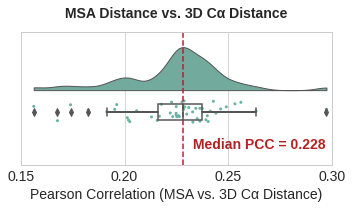

In [72]:
TM_CORRELATION_RESULTS_FILE = "../Output/Dynamics/MSA_vs_3D_Correlation_TM_Only.csv"
FIG2C_FILE = "../Output/Dynamics/Figure2c_MSA_vs_3D_Correlation.png"
plot_2c_raincloud(TM_CORRELATION_RESULTS_FILE, FIG2C_FILE)